# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, let's import the necessary libraries. Make sure to define your paths in the .env file located at: .../Robyn/python/src/tutorials/.env

Two paths are defined here: ROBYN_BASE_PATH and PYTHONPATH

In [1]:
from dotenv import load_dotenv
import os
import sys

# Load environment variables from .env file
load_dotenv(dotenv_path=".env.sample")
# Retrieve the ROBYN_BASE_PATH environment variable
base_path = os.getenv("ROBYN_BASE_PATH")
if not base_path:
    raise EnvironmentError("Please set the ROBYN_BASE_PATH environment variable")
# Retrieve the PYTHONPATH environment variable
python_path = os.getenv("PYTHONPATH")
if not python_path:
    raise EnvironmentError("Please set the PYTHONPATH environment variable in the .env file")
# Append the paths to sys.path to recognize them as valid Python package paths
sys.path.append(base_path)
sys.path.append(python_path)

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import pyreadr
from typing import Dict, Any
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.ridge_model_builder import RidgeModelBuilder
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeaturizedMMMData, FeatureEngineering

## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
def load_data() -> Dict[str, pd.DataFrame]:
    base_path = os.getenv("ROBYN_BASE_PATH")
    if not base_path:
        raise EnvironmentError("Please set the ROBYN_BASE_PATH environment variable")

    simulated_weekly_path = os.path.join(base_path, "dt_simulated_weekly.RData")
    prophet_holidays_path = os.path.join(base_path, "dt_prophet_holidays.RData")

    result = pyreadr.read_r(simulated_weekly_path)
    dt_simulated_weekly = result["dt_simulated_weekly"]
    result_holidays = pyreadr.read_r(prophet_holidays_path)
    dt_prophet_holidays = result_holidays["dt_prophet_holidays"]

    return {"dt_simulated_weekly": dt_simulated_weekly, "dt_prophet_holidays": dt_prophet_holidays}


data = load_data()

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(data: Dict[str, pd.DataFrame]) -> MMMData:
    dt_simulated_weekly = data["dt_simulated_weekly"]

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        factor_vars=["events"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(data)

## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
def setup_hyperparameters() -> Hyperparameters:
    return Hyperparameters(
        hyperparameters={
            "facebook_S_alphas": [0.5, 3],
            "facebook_S_gammas": [0.3, 1],
            "facebook_S_thetas": [0, 0.3],
            "print_S_alphas": [0.5, 3],
            "print_S_gammas": [0.3, 1],
            "print_S_thetas": [0.1, 0.4],
            "tv_S_alphas": [0.5, 3],
            "tv_S_gammas": [0.3, 1],
            "tv_S_thetas": [0.3, 0.8],
            "search_S_alphas": [0.5, 3],
            "search_S_gammas": [0.3, 1],
            "search_S_thetas": [0, 0.3],
            "ooh_S_alphas": [0.5, 3],
            "ooh_S_gammas": [0.3, 1],
            "ooh_S_thetas": [0.1, 0.4],
            "newsletter_alphas": [0.5, 3],
            "newsletter_gammas": [0.3, 1],
            "newsletter_thetas": [0.1, 0.4],
        },
        adstock="geometric",
        lambda_=0.0,
        train_size=[0.5, 0.8],
    )


# Setup Hyperparameters
hyperparameters = setup_hyperparameters()
print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=data["dt_prophet_holidays"],
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)

In [7]:
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)
featurized_mmm_data = feature_engineering.perform_feature_engineering()

/Users/yijuilee/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
10:28:57 - cmdstanpy - INFO - Chain [1] start processing
2024-10-15 10:28:57 - cmdstanpy - INFO - Chain [1] start processing
10:28:57 - cmdstanpy - INFO - Chain [1] done processing
2024-10-15 10:28:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet decomposition complete.
Processing tv_S
Processing ooh_S
Processing print_S
Processing facebook_S
Processing search_S
Feature engineering complete.


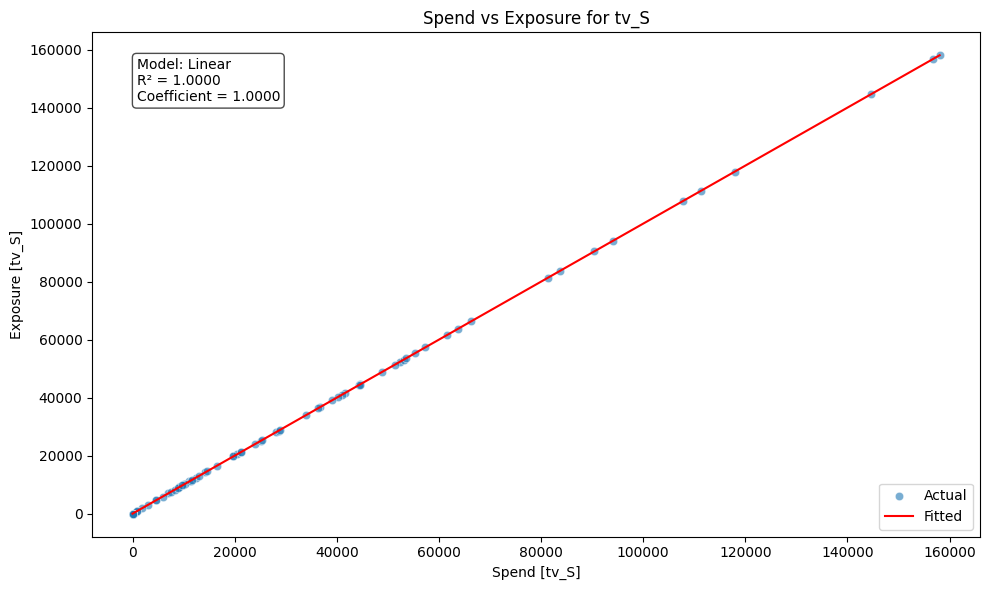

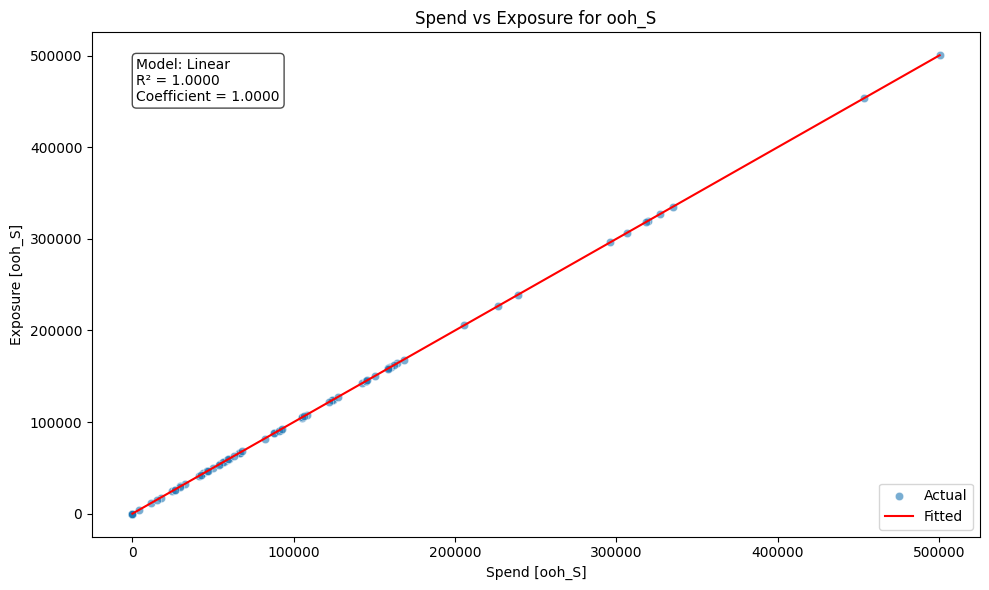

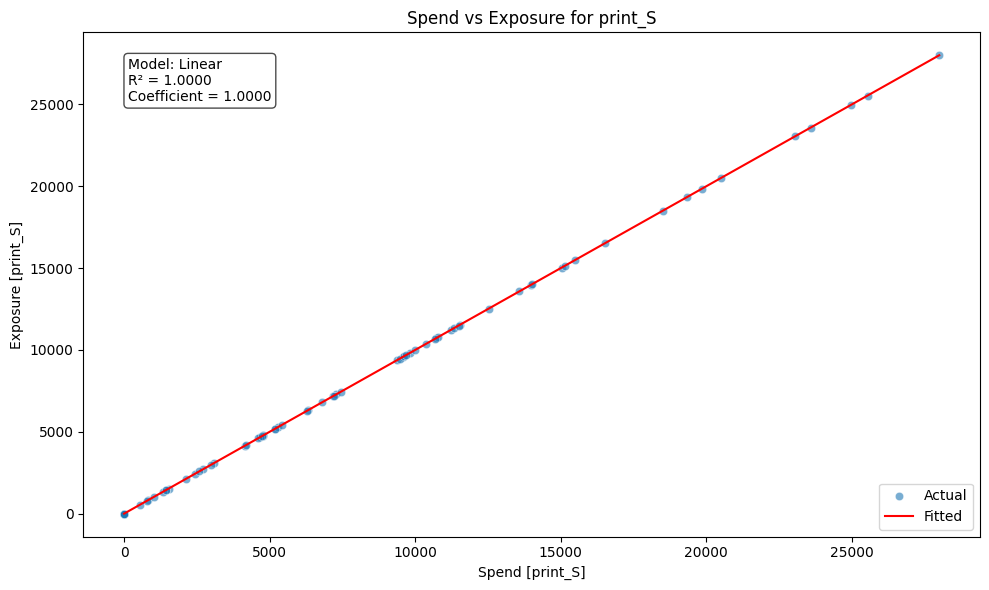

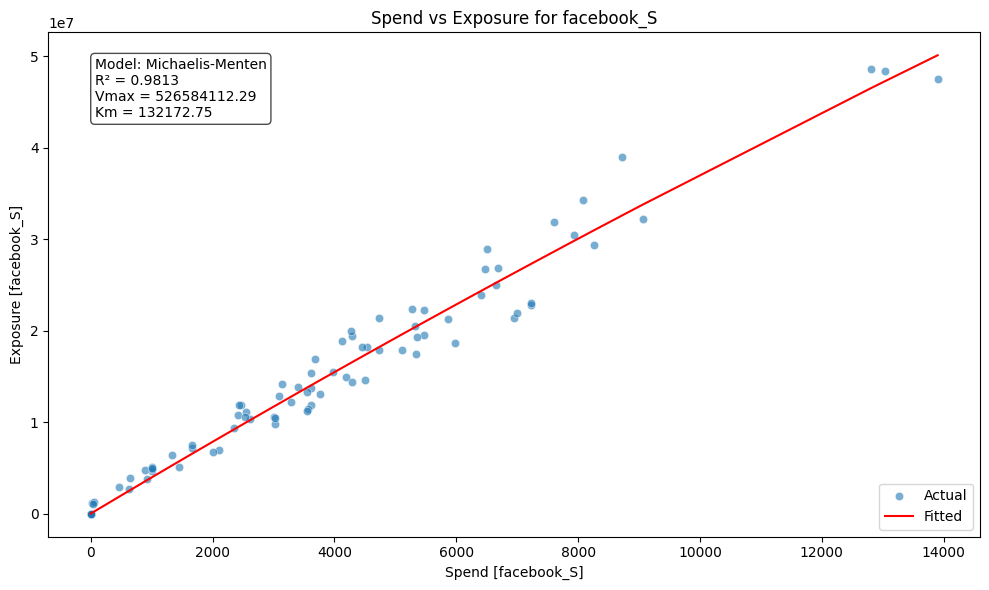

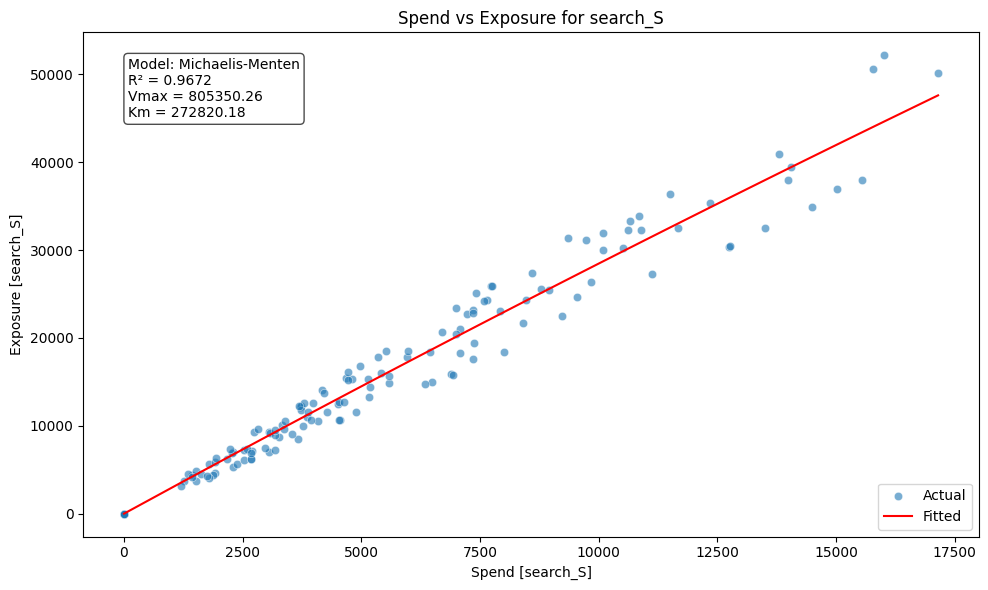

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)


# Plot spend-exposure relationship for each channel
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

In [13]:
print("After Prophet fitting Python data:")
print(featurized_mmm_data.dt_mod[["trend", "season", "holiday", "events"]].describe())

After Prophet fitting Python data:
              trend        season       holiday      events
count  2.080000e+02  2.080000e+02  2.080000e+02  208.000000
mean   2.464408e+06 -4.200662e+03  4.485713e+04    0.006711
std    2.734418e+04  6.749420e+05  1.770986e+05    0.074450
min    2.410718e+06 -1.051064e+06 -3.339534e+05    0.000000
25%    2.440887e+06 -6.708996e+05  0.000000e+00    0.000000
50%    2.466341e+06 -5.934451e+04  0.000000e+00    0.000000
75%    2.489693e+06  6.465492e+05  0.000000e+00    0.000000
max    2.503485e+06  1.217579e+06  1.039102e+06    1.000000


In [16]:
featurized_mmm_data.dt_mod["events"].unique()

array([0.        , 1.        , 0.39590026])

In [12]:
from utils.data_mapper import export_data, import_data, save_data_to_json, load_data_from_json
from utils.compare_data import compare_featurized_mmm_data

# # Load data from JSON
# loaded_data = load_data_from_json(
#     "/Users/yijuilee/project_robyn/robynpy_interfaces/Robyn/python/src/tutorials/data/R/exported_data.json"
# )
# imported_data = import_data(loaded_data)

compare_featurized_mmm_data(
    "/Users/yijuilee/project_robyn/robynpy_interfaces/Robyn/python/src/tutorials/data/R/exported_data.json",
    featurized_mmm_data,
)

('\ndt_mod DataFrame Comparison:\nShape Comparison:\n+---------+------------+--------------+\n|         |   R/Python |   New Python |\n+=========+============+==============+\n| Rows    |        208 |          208 |\n+---------+------------+--------------+\n| Columns |         13 |           13 |\n+---------+------------+--------------+\n\nColumn Comparison:\n+-------------------------------------------------------------------------------------------------------------------------+--------------------+----------------------+\n| Common Columns                                                                                                          | Only in R/Python   | Only in New Python   |\n+=========================================================================================================================+====================+======================+\n| competitor_sales_B, dep_var, ds, events, facebook_S, holiday, newsletter, ooh_S, print_S, search_S, season, trend, tv_S |        

In [ ]:
print("After Prophet fitting Python data:")
print(featurized_mmm_data.dt_mod[["trend", "season", "holiday"]].describe())